In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Thresholding

### simple thresholding

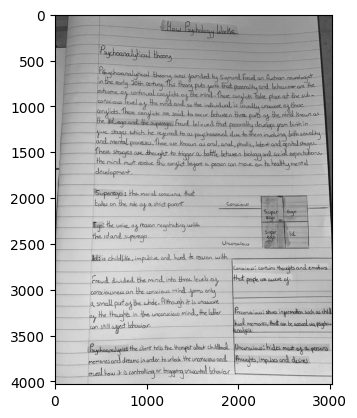

In [4]:
img=cv2.imread("./images/notes.jpg",0)#read as gray sacle
plt.imshow(img,cmap='grey')

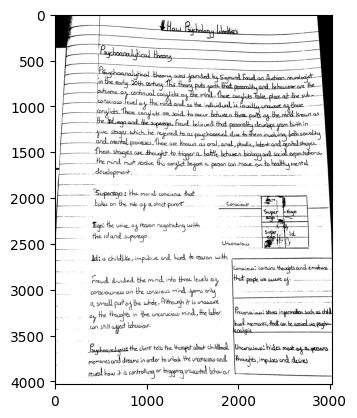

In [5]:
retval,binary=cv2.threshold(img,130,255,cv2.THRESH_BINARY)
plt.imshow(binary,'grey')

### adaptive thresholding

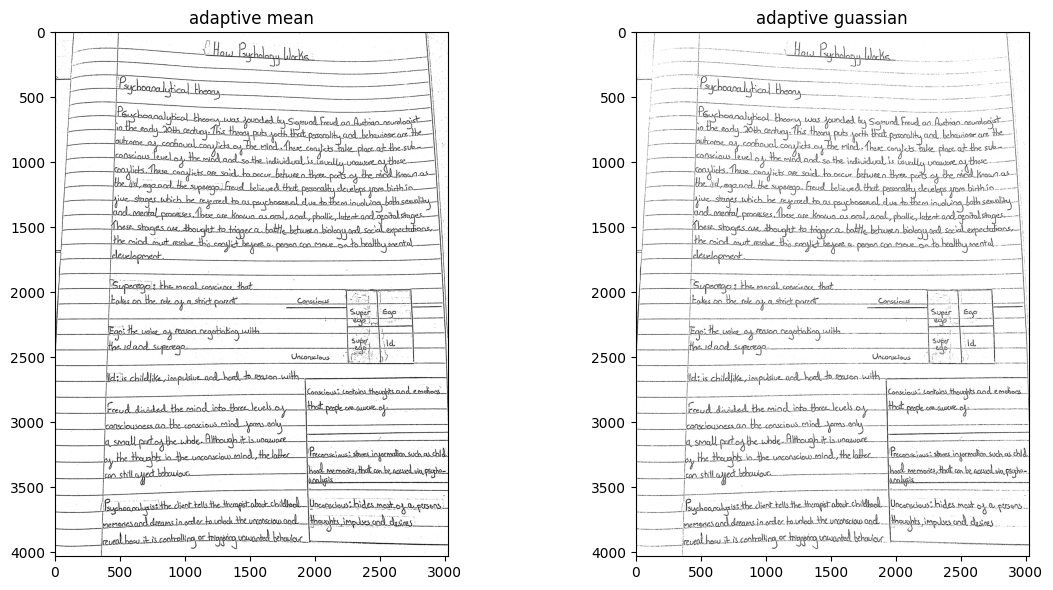

In [6]:

adaptive_m=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,9)
adaptive_g=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,9)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(adaptive_m,cmap='grey')
plt.title("adaptive mean")

plt.subplot(1,2,2)
plt.imshow(adaptive_g,cmap='grey')
plt.title("adaptive guassian")
plt.tight_layout()
plt.show()



### k means clustring

In [7]:
shapes=cv2.imread("./images/shapes.jpg")
shapes=cv2.cvtColor(shapes,cv2.COLOR_BGR2RGB)
pixel_values=shapes.reshape((-1,3))
pixel_values=np.float32(pixel_values)
print(pixel_values)

[[255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]
 ...
 [255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]]


In [8]:
criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,100,0.2)
k=3
_,labels,centers=cv2.kmeans(pixel_values,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
print(labels.shape)
print(centers)

(979020, 1)
[[ 77.26889  149.59561  160.69931 ]
 [254.70805  253.737    254.1127  ]
 [227.10336  120.95464   84.173836]]


Text(0.5, 1.0, 'segmented img')

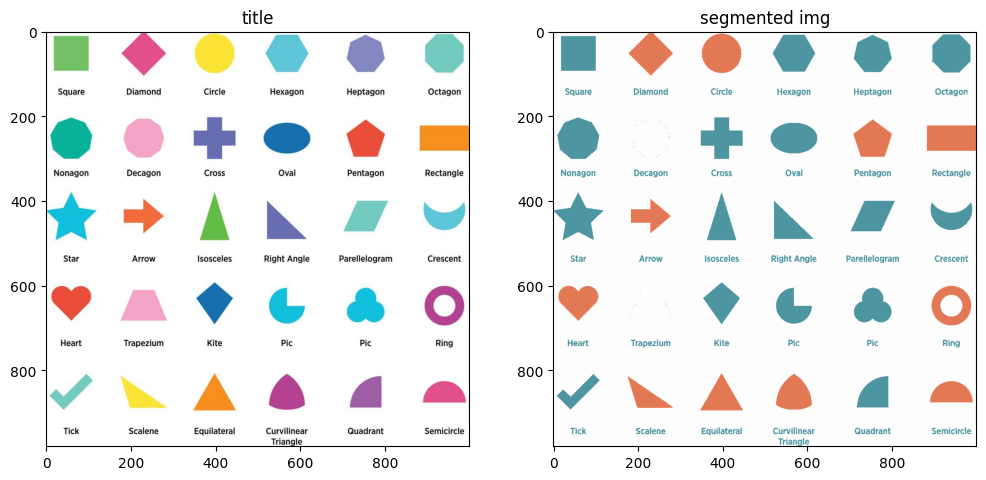

In [9]:
centers=np.uint8(centers)
segmented_img=centers[labels.flatten()]
segmented_img=segmented_img.reshape(shapes.shape)

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(shapes)
plt.title("title")


plt.subplot(1,2,2)
plt.imshow(segmented_img)
plt.title("segmented img")


### watershed algorithm

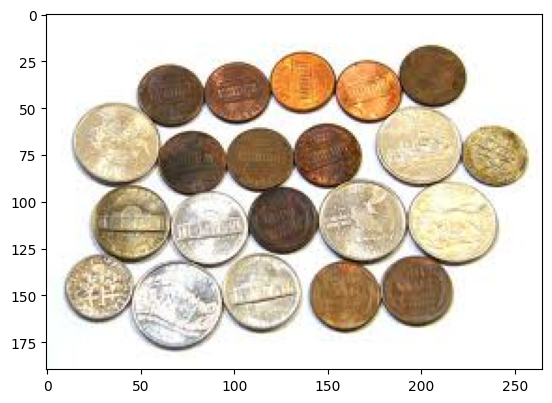

In [210]:
coins=cv2.imread("./images/coins.jpg")
coins=cv2.cvtColor(coins,cv2.COLOR_BGR2RGB)
og_img=coins.copy()
plt.imshow(coins)

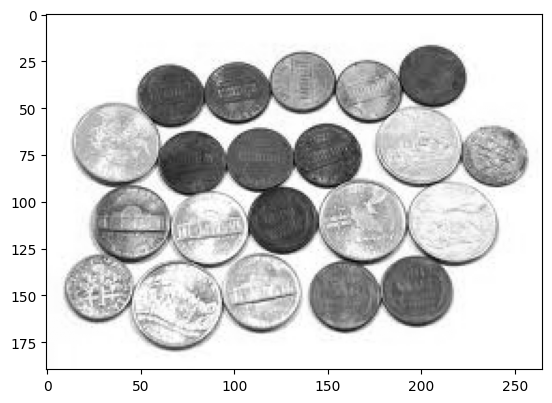

In [211]:
gray=cv2.cvtColor(coins,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

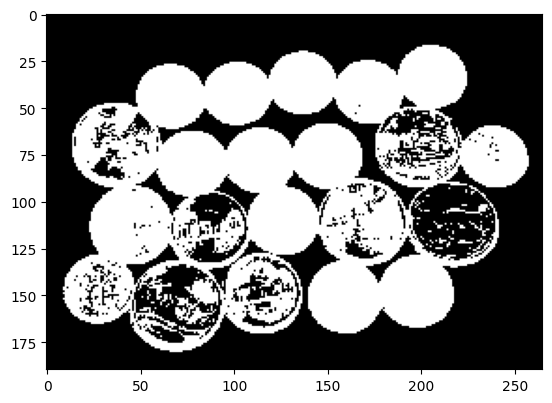

In [212]:
_,thresh=cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='gray')

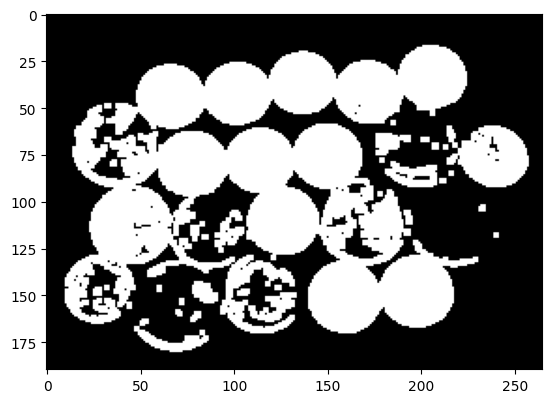

In [213]:
kernel=np.ones((3,3),np.uint8)
opening=cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=1)
plt.imshow(opening,cmap='gray')

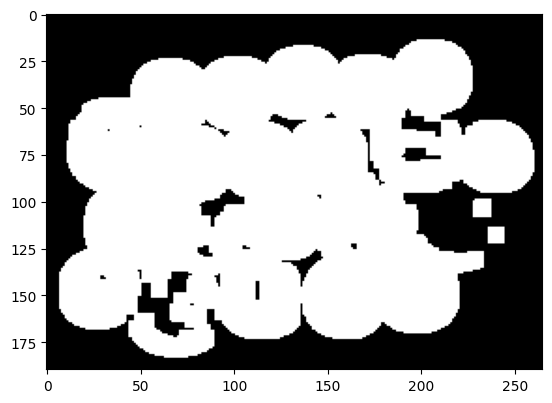

In [214]:
sure_bg=cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg,cmap='gray')

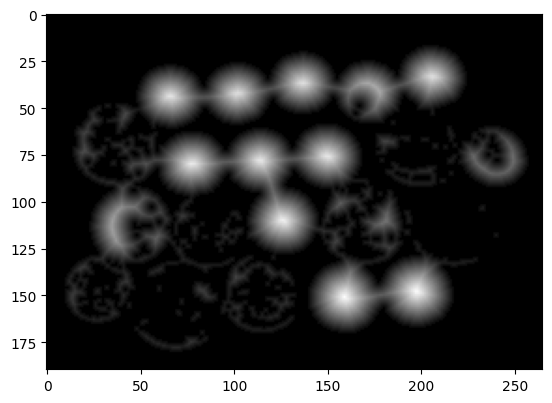

In [215]:
from cv2 import distanceTransform


dist_transform=cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform,cmap='gray')

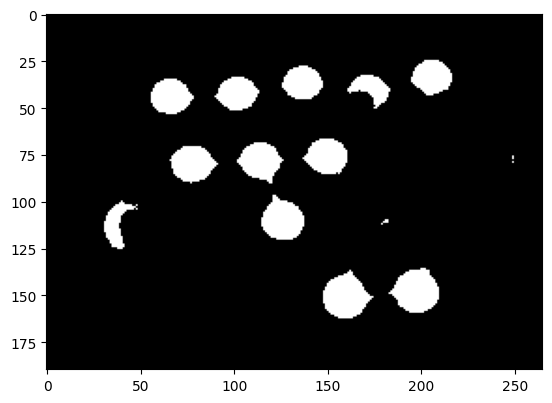

In [223]:
_,sure_fg=cv2.threshold(dist_transform,0.41*dist_transform.max(),255,0)
sure_fg=np.uint8(sure_fg)
plt.imshow(sure_fg,cmap='gray')

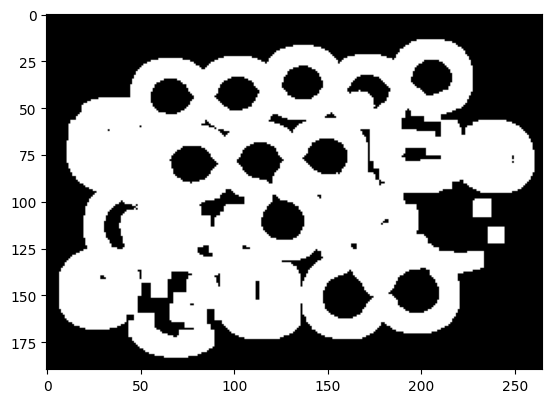

In [224]:
unknown=cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap='gray')

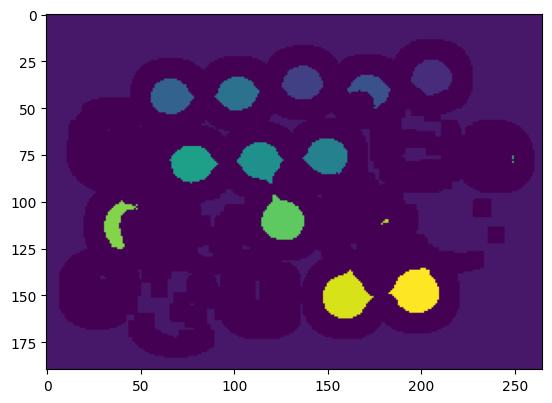

In [225]:
_,markers=cv2.connectedComponents(sure_fg)
markers+=1
markers[unknown==255]=0
plt.imshow(markers)

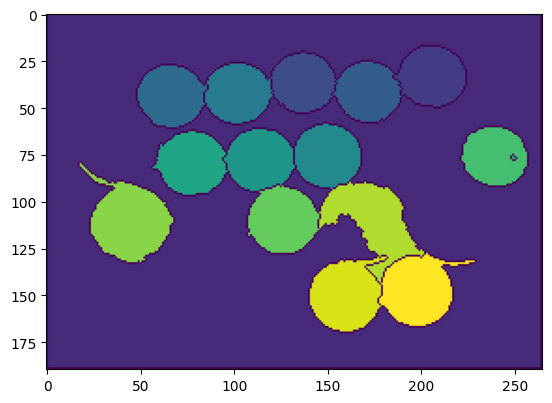

In [226]:
markers=cv2.watershed(coins,markers)
plt.imshow(markers)

In [227]:
coin_mask=np.zeros_like(gray)
unique_labels=np.unique(markers)
instance_number=1
font=cv2.FONT_HERSHEY_SIMPLEX

for label in unique_labels:
    if label==0 or label==-1:
        continue
    mask=np.uint8(markers==label)
    contours,_=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area=cv2.contourArea(contour)
        perimeter=cv2.arcLength(contour,True)
        if perimeter==0:
            continue
        circularity=4*np.pi*(area/(perimeter*perimeter))
        if 0.4 < circularity < 2.0 and area > 200:
            cv2.drawContours(og_img,[contour],-1,(0,255,0),2)
            x,y,w,h=cv2.boundingRect(contour)
            cv2.putText(og_img,f'{instance_number}',(x,y-10),font,0.6,(255,0,0),2)
            coin_mask=cv2.bitwise_or(coin_mask,mask)
            cv2.rectangle(og_img,(x-5,y-5),(x+w+5,y+h+5),(160,150,250),2)
            instance_number+=1



<function matplotlib.pyplot.show(close=None, block=None)>

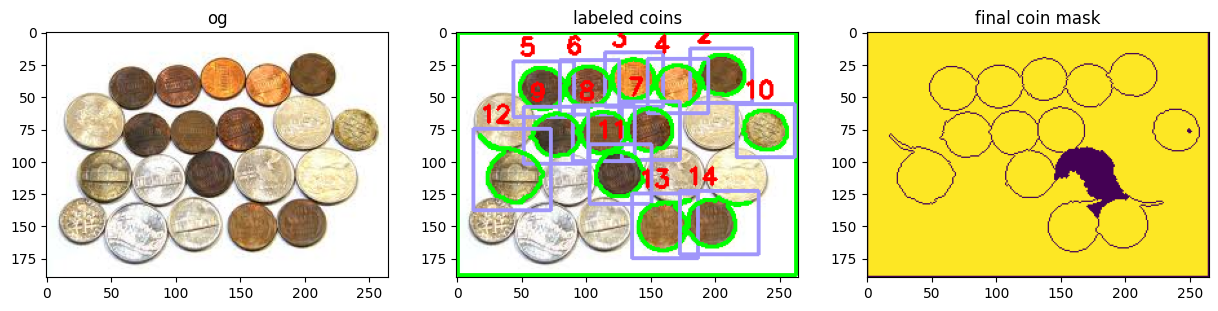

In [228]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(coins)
plt.title("og")


plt.subplot(1,3,2)
plt.imshow(og_img)
plt.title("labeled coins")

plt.subplot(1,3,3)
plt.imshow(coin_mask)
plt.title("final coin mask")

plt.show